Iteration 1/500 - Max error: 42.82404722139289
Iteration 2/500 - Max error: 36.24190832534727
Iteration 3/500 - Max error: 36.24189340675716
Iteration 4/500 - Max error: 36.241878485469215
Iteration 5/500 - Max error: 36.241863561497155
Iteration 6/500 - Max error: 36.24184863484496
Iteration 7/500 - Max error: 36.241833705514395
Iteration 8/500 - Max error: 36.24181877350624
Iteration 9/500 - Max error: 36.24180383882138
Iteration 10/500 - Max error: 36.24178890146031
Iteration 11/500 - Max error: 36.24177396142325
Iteration 12/500 - Max error: 36.24175901871035
Iteration 13/500 - Max error: 36.241744073321584
Iteration 14/500 - Max error: 36.24172912525699
Iteration 15/500 - Max error: 36.241714174516595
Iteration 16/500 - Max error: 36.241699221100376
Iteration 17/500 - Max error: 36.24168426500835
Iteration 18/500 - Max error: 36.24166930624051
Iteration 19/500 - Max error: 36.241654344796814
Iteration 20/500 - Max error: 36.24163938067724
Iteration 21/500 - Max error: 36.241624413

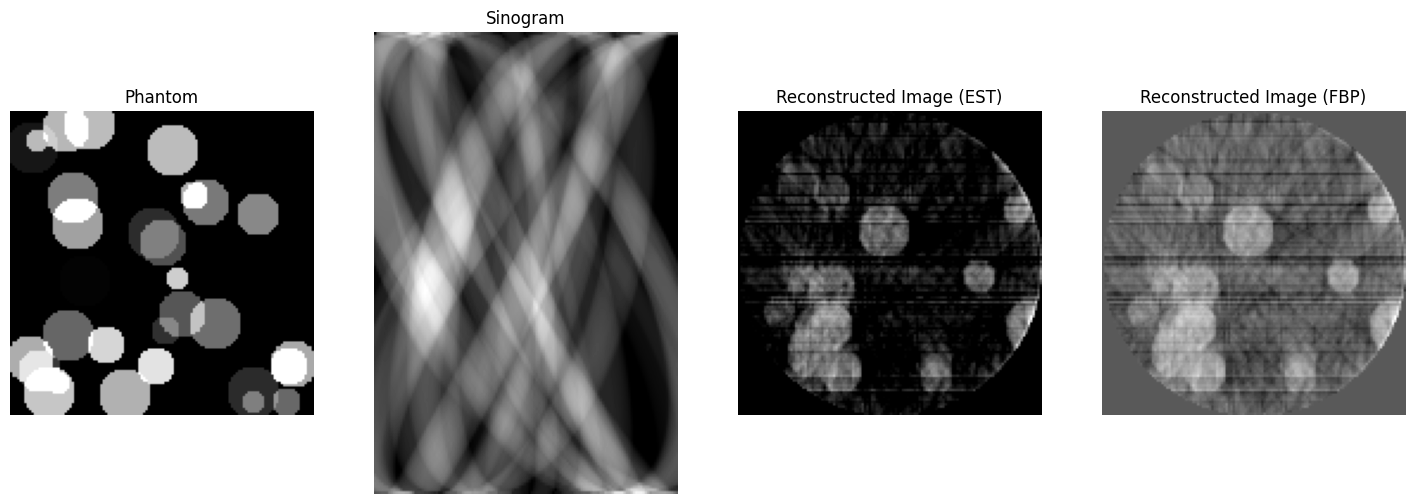

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.ndimage import rotate
from skimage.draw import disk

def EST_Angles(num_projections):
    """
    Generate projection angles that are equally spaced in Fourier space.

    Parameters:
    - num_projections: int, number of projections to generate.

    Returns:
    - theta: 1D array, the projection angles.
    """
    return np.arcsin(np.linspace(-1, 1, num_projections)) * 180 / np.pi

def make_phantom(size, num_disks):
    """
    Create a foam-like phantom with multiple disks of varying sizes and intensities.

    Parameters:
    - size: int, the size (height and width) of the phantom image.
    - num_disks: int, the number of disks to generate.

    Returns:
    - phantom: 2D array, the generated phantom image.
    """
    phantom = np.zeros((size, size))

    rng = np.random.default_rng()
    for _ in range(num_disks):
        # Random position
        x, y = rng.integers(0, size, size=2)
        # Random radius
        radius = rng.integers(5, size // 10)
        # Random intensity
        intensity = rng.random()

        rr, cc = disk((x, y), radius, shape=phantom.shape)
        phantom[rr, cc] += intensity
        phantom = np.clip(phantom, 0, 1)  # Ensure intensity stays within [0, 1]

    return phantom

def EST_reco(sinogram, theta, num_iterations=200, tolerance=1e-5, learning_rate=0.00005):
    """
    Perform Equally Sloped Tomography (EST) reconstruction using simple gradient descent.

    Parameters:
    - sinogram: 2D array, the sinogram data (projections).
    - theta: 1D array, the projection angles.
    - num_iterations: int, number of iterations for the EST algorithm.
    - tolerance: float, tolerance for early stopping based on maximum error change.
    - learning_rate: float, step size for the updates.

    Returns:
    - reconstructed_image: 2D array, the reconstructed image.
    """
    num_projections, sx = sinogram.shape

    # Initial guess using Filtered Back Projection (FBP)
    initial_guess = iradon(np.rot90(sinogram, -1), theta=theta, circle=True)
    estimated_image = initial_guess.copy()

    previous_error = np.inf

    for iteration in range(num_iterations):
        # Forward projection
        projections = np.zeros((num_projections, sx))

        for i, angle in enumerate(theta):
            rotated_image = rotate(estimated_image, angle, reshape=False, order=1)
            projection = np.sum(rotated_image, axis=0)

            if projection.shape[0] > sx:
                projection = projection[:sx]
            elif projection.shape[0] < sx:
                projection = np.pad(projection, (0, sx - projection.shape[0]), 'constant')

            projections[i, :] = projection

        # Compute error
        error = sinogram - projections
        max_error = np.max(np.abs(error))

        print(f"Iteration {iteration + 1}/{num_iterations} - Max error: {max_error}")

        # Early stopping if error change is below the tolerance
        if np.abs(previous_error - max_error) < tolerance:
            print(f"Convergence reached at iteration {iteration + 1}")
            break

        previous_error = max_error

        # Backproject the error
        backprojected_error = np.zeros_like(estimated_image)
        for i, angle in enumerate(theta):
            expanded_error = np.zeros_like(estimated_image)
            expanded_error[:, :sx] = error[i, :].reshape(-1, sx)
            rotated_error = rotate(expanded_error, -angle, reshape=False, order=1)
            backprojected_error += rotated_error

        # Normalize the backprojected error to avoid excessive accumulation
        if np.max(np.abs(backprojected_error)) != 0:
            backprojected_error /= np.max(np.abs(backprojected_error))

        # Apply gradient descent update
        estimated_image += learning_rate * (backprojected_error / num_projections)
        estimated_image = np.maximum(estimated_image, 0)  # Apply non-negativity constraint

    return estimated_image

def make_sino(phantom, theta):
    sinogram = radon(phantom, theta=theta, circle=True)
    return np.rot90(sinogram, 1)

# Example usage
if __name__ == "__main__":
    size = 128
    num_disks = 30
    phantom = make_phantom(size, num_disks)

    num_projections = 160 
    theta = EST_Angles(num_projections)
    sinogram = make_sino(phantom, theta)

    # Perform EST reconstruction
    EST_data = EST_reco(sinogram, theta, num_iterations=500, learning_rate=0.0005)

    # Perform FBP reconstruction
    FBP_data = iradon(np.rot90(sinogram, -1), theta=theta, circle=True)

    # Plot results
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.title("Phantom")
    plt.imshow(phantom, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Sinogram")
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Reconstructed Image (EST)")
    plt.imshow(reconstructed_image_est, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Reconstructed Image (FBP)")
    plt.imshow(reconstructed_image_fbp, cmap='gray')
    plt.axis('off')

    plt.show()